# SPXQuery Quickstart Demo

This notebook demonstrates the flexible, resumable pipeline features of the `spxquery` package.

**Point Source:** Cloverleaf quasar (RA=213.9427080°, Dec=+11.4953890°, z=2.56)

**Package Version:** v0.2.2

## Features Demonstrated

1. **Advanced Configuration** (v0.2.2) - FWHM-based apertures and window background
2. **One-click pipeline execution** - Run everything with a single function call
3. **Smart resume with YAML** - Human-readable state files with automatic loading
4. **Manual step execution** - Run individual stages with dependency checking
5. **Method comparisons** (v0.2.2) - Compare background and aperture methods
6. **Parameter tuning** (v0.2.2) - Interactive exploration of optimal settings

## SPHEREx Bad Pixel Flags Reference

The `bad_flags` parameter specifies which pixel quality flags to reject during visualization.

**Default bad_flags: [0, 1, 2, 6, 7, 9, 10, 11, 14, 15, 17, 19]**

| Flag Name    | Bit | Flag Name    | Bit |
|--------------|-----|--------------|-----|
| TRANSIENT    | 0   | COLD         | 11  |
| OVERFLOW     | 1   | FULLSAMPLE   | 12  |
| SUR_ERROR    | 2   | PHANMISS     | 14  |
| NONFUNC      | 6   | NONLINEAR    | 15  |
| DICHROIC     | 7   | PERSIST      | 17  |
| MISSING_DATA | 9   | OUTLIER      | 19  |
| HOT          | 10  | SOURCE       | 21  |

**Note:** The FLAGS extension in SPHEREx FITS files uses a bitmap where multiple flags can be set for a single pixel. The pipeline marks measurements as "bad" if ANY of the specified flag bits are set.

**Usage examples:**
```python
bad_flags=[0, 1, 2, 6, 7, 9, 10, 11, 14, 15, 17, 19]  # Default: comprehensive quality control
bad_flags=[]                      # No flag filtering (use all data)
```

---

### Automatic Variance Repair (NEW in v0.2.2)

**Problem**: Some SPHEREx images contain pixels with NaN variance but valid flux values, typically due to flagged conditions.

**Solution**: The pipeline automatically repairs variance for flagged pixels:
- **Validates assumption**: Checks that NaN variance correlates with non-zero flags
- **Estimates variance**: Uses median of valid variance values across the image
- **Fails safely**: Raises error if NaN variance found without flags (unexpected data quality issue)

**Benefits:**
- Preserves observations that would otherwise fail photometry
- Provides reasonable error estimates for flagged pixels
- Maintains SNR-based quality control
- No manual intervention required

**Log message example:**
```
INFO - Repaired 23 pixels with NaN variance using median variance (1.234e-06). 
       All repaired pixels have non-zero flags.
```

In [1]:
# Import required modules
from pathlib import Path

from spxquery import QueryConfig, Source, SPXQueryPipeline
from spxquery.core.pipeline import run_pipeline
from spxquery.utils.helpers import setup_logging

# Set up logging
setup_logging("INFO")

## Generate Spectrophotometry for a Single Source

**NEW IN v0.2.2**: Enhanced photometry with adaptive apertures and flexible background estimation!

The advanced parameter system allows you to customize photometry, visualization, and download parameters beyond the basic pipeline settings.

### What's New in v0.2.2

**Adaptive Aperture Sizing:**
- **FWHM-based apertures**: Automatically size apertures based on PSF FWHM
- **Automatic fallback**: Falls back to fixed aperture if FWHM estimation fails
- Parameters: `aperture_method` ('fixed' or 'fwhm'), `fwhm_multiplier`

**Flexible Background Estimation:**
- **Window method**: Rectangular background region (alternative to annulus)
- **Automatic aperture exclusion**: Pixels intersecting the aperture are automatically excluded
- Parameters: `background_method` ('annulus' or 'window'), `window_size`

**Key features:**
- Export default parameters to YAML template with inline comments
- Edit parameters manually for fine-tuning
- Load custom parameters into pipeline
- Priority system: explicit params > YAML file > defaults

### Parameter Setting (v0.2.2 Features)

Here's how to use the new photometry features directly in your pipeline:

In [2]:
# FWHM-based adaptive apertures
from spxquery.core.config import (
    PhotometryConfig,
    QueryConfig,
    Source,
    AdvancedConfig,
    DownloadConfig,
    VisualizationConfig,
)

# Define our target source
source = Source(
    name="cloverleaf",
    ra=213.9427080,  # Right ascension in degrees
    dec=11.4953890,  # Declination in degrees
)

# Define the output directory
output_dir = Path("./demo_data/cloverleaf")


config_all = AdvancedConfig(
    # === Query Configuration ===
    query=QueryConfig(
        source=source,
        output_dir=output_dir,
        bands=["D1", "D2", "D3", "D4", "D5", "D6"],  # SPHEREx bands to query
    ),
    # === Download Configuration ===
    download=DownloadConfig(
        # === Image settings ===
        cutout_size="60px",  # Size of cutout images; None for full image (e.g., "200px", "3arcmin")
        cutout_center=None,  # Center of cutout; defaults to source coordinates (e.g., "70,20", "300.5,120px")
        # === Download Settings ===
        max_retries=3,  # Number of retry attempts for failed downloads
        max_download_workers=5,  # Number of parallel download workers
        # === Advanced Users Only ===
        chunk_size=8192,  # Only for advanced users: size of data chunks to read (bytes)
        timeout=300,  # Only for advanced users: HTTP timeout (seconds)
        user_agent="SPXQuery/0.2.2",  # Only for advanced users: User agent string for HTTP requests
    ),
    # === Photometry Configuration ===
    photometry=PhotometryConfig(
        # === Aperture Configuration ===
        aperture_method="fwhm",  # "fixed" or "fwhm" - aperture sizing method
        fwhm_multiplier=2.5,  # Multiplier for FWHM-based apertures (aperture = FWHM × multiplier)
        aperture_diameter=3.0,  # Aperture diameter in pixels (fixed method OR fallback)
        # === Background Configuration ===
        background_method="window",  # "annulus" or "window" - background estimation method
        window_size=50,  # Window size for window method (int for square, tuple for rectangular)
        # === Annulus Parameters (Only valid if aperture_method="annulus") ===
        annulus_inner_offset=1.414,  # Gap between aperture and annulus inner radius (pixels)
        min_annulus_area=10,  # Minimum annulus area (pixels)
        max_outer_radius=5.0,  # Maximum outer annulus radius (pixels)
        max_annulus_attempts=5,  # Max attempts to expand annulus if insufficient pixels
        annulus_expansion_step=0.5,  # Step size for annulus expansion (pixels)
        # === Background Statistics ===
        min_usable_pixels=10,  # Minimum unflagged pixels required for background estimation
        bg_sigma_clip_sigma=3.0,  # Sigma threshold for background sigma clipping
        bg_sigma_clip_maxiters=3,  # Maximum iterations for background sigma clipping
        # === Other Photometry Parameters ===
        subtract_zodi=True,  # Whether to subtract zodiacal light background from images
        zodi_scale_min=0.0,  # Minimum allowed zodiacal scaling factor
        zodi_scale_max=10.0,  # Maximum allowed zodiacal scaling factor
        pixel_scale_fallback=6.2,  # Fallback pixel scale (arcsec/pixel) when WCS fails
        # === Processing & Quality Control ===
        max_processing_workers=10,  # Parallel processing
        bad_flags=[0, 1, 2, 6, 7, 9, 10, 11, 15],  # Photometry fails if aperture contains flagged pixels
    ),
    # === Visualization Configuration ===
    visualization=VisualizationConfig(
        # === Quality Control ===
        sigma_threshold=5.0,  # Minimum SNR (flux/flux_err) for quality control filtering
        # === Plot Type ===
        use_magnitude=False,  # If True, plot AB magnitude instead of flux
        show_errorbars=True,  # If True, show error bars on plots
        # === Color Maps ===
        wavelength_cmap="rainbow",  # Colormap for wavelength coding in light curves
        date_cmap="viridis",  # Colormap for date coding in spectra
        # === Outlier Removal ===
        sigma_clip_sigma=5.0,  # Sigma threshold for outlier removal in plots
        sigma_clip_maxiters=10,  # Maximum iterations for sigma clipping
        # === Y-axis Limits ===
        ylim_percentile_min=1.0,  # Lower percentile for smart y-axis limits (0-100)
        ylim_percentile_max=99.0,  # Upper percentile for smart y-axis limits (0-100)
        ylim_padding_fraction=0.1,  # Padding fraction added to y-axis range
        # === Marker Sizes ===
        marker_size_good=1.5,  # Marker size for good measurements
        marker_size_rejected=2.0,  # Marker size for rejected measurements
        marker_size_upper_limit=3.0,  # Marker size for upper limit arrows
        # === Transparency ===
        errorbar_alpha=0.2,  # Transparency for error bars (0-1)
        marker_alpha=0.9,  # Transparency for markers (0-1)
        # === Line Widths ===
        errorbar_linewidth=0.5,  # Line width for error bars in points
        # === Figure Settings ===
        figsize=(10, 8),  # Figure size in inches (width, height)
        dpi=150,  # Resolution in dots per inch for saved figures
    ),
)

# Save these settings for future use
config_all.to_yaml_file(output_dir / "config_params.yaml")

**Or use a YAML template and Edit outside**

In [3]:
# Export default parameters to a JSON template
from spxquery.utils.params import export_default_parameters

# Export to custom directory
params_file = export_default_parameters(output_dir, filename="config_params.yaml")

print(f"\nParameter template created at: {params_file}")

2025-11-13 00:33:00 - spxquery.utils.params - INFO - Default parameters exported to demo_data/cloverleaf/config_params.yaml



Advanced Parameters Template Exported
File location: demo_data/cloverleaf/config_params.yaml

This template contains customizable parameters for:
  • Photometry (aperture, background annulus, sigma clipping)
  • Visualization (colormaps, marker sizes, figure settings)
  • Downloads (chunk size, timeouts, retries)

NOTE: This template does NOT include source information (ra/dec).
      You must provide source coordinates when running the pipeline.

Next steps:
  1. Edit config_params.yaml to customize parameters (YAML format with comments)
  2. Use the file in your pipeline with:
     • QueryConfig(source=..., advanced_params_file='demo_data/cloverleaf/config_params.yaml')
     • run_pipeline(ra=..., dec=..., advanced_params_file='demo_data/cloverleaf/config_params.yaml')


Parameter template created at: demo_data/cloverleaf/config_params.yaml


In [4]:
# Load the file back into a QueryConfig object
config_all = AdvancedConfig.from_yaml_file(params_file)

2025-11-13 00:33:00 - spxquery.core.config - INFO - Loaded advanced parameters from demo_data/cloverleaf/config_params.yaml


**You can also update your parameters after build up the config**

In [5]:
# Only name of the parameter is needed. Package will identify which category it belongs to.
print(config_all.query.source.name)
config_all.update(source=source, output_dir=output_dir, max_processing_workers=1)
print(config_all.query.source.name)

2025-11-13 00:33:00 - spxquery.core.config - INFO - Updated parameters: ['source', 'output_dir', 'max_processing_workers']


MySource
cloverleaf


### Use Custom Parameters in Pipeline

There are two ways to use custom parameters:

2025-11-13 00:33:00 - spxquery.core.pipeline - INFO - Initialized pipeline for source at RA=213.942708, Dec=11.495389
2025-11-13 00:33:00 - spxquery.core.pipeline - INFO - Pipeline stages: ['query', 'download', 'processing', 'visualization']
2025-11-13 00:33:00 - spxquery.core.pipeline - INFO - State file: cloverleaf.yaml
2025-11-13 00:33:00 - spxquery.core.pipeline - INFO - Starting full pipeline execution
2025-11-13 00:33:00 - spxquery.core.pipeline - INFO - Pipeline stages: ['query', 'download', 'processing', 'visualization']
2025-11-13 00:33:00 - spxquery.core.pipeline - INFO - Running query stage
2025-11-13 00:33:00 - spxquery.core.query - INFO - Querying SPHEREx observations for source at RA=213.942708, Dec=11.495389



Method 1: Using SPXQueryPipeline with advanced_params_file

✓ Custom parameters loaded!
  Visualization DPI: 150
  Figure size: (10, 8)
  Wavelength colormap: rainbow
  BG sigma clipping: 3.0


2025-11-13 00:33:04 - spxquery.core.query - INFO - Found 108 observations spanning 33.1 days
2025-11-13 00:33:04 - spxquery.core.pipeline - INFO - Marked stage 'query' as complete
2025-11-13 00:33:04 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=download, completed=['query']
2025-11-13 00:33:04 - spxquery.core.pipeline - INFO - Running download stage (skip_existing=True)
2025-11-13 00:33:04 - spxquery.core.download - INFO - Starting parallel download of 108 files
2025-11-13 00:33:04 - spxquery.core.download - INFO - Download settings: timeout=300s, retries=3, workers=4



SPHEREx Archive Search Results
Source: RA=213.942708, Dec=11.495389
        Name: cloverleaf
Query time: 2025-11-13 00:33:04

Total observations found: 108

Observations by band:
  D1 (0.75-1.09 μm):  18 observations
  D2 (1.10-1.62 μm):  18 observations
  D3 (1.63-2.41 μm):  18 observations
  D4 (2.42-3.82 μm):  18 observations
  D5 (3.83-4.41 μm):  18 observations
  D6 (4.42-5.00 μm):  18 observations

Time span: 33.1 days
Total data volume: 0.00 GB



Downloading:   0%|          | 0/108 [00:00<?, ?files/s]2025-11-13 00:33:04 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_1.fits - already exists
2025-11-13 00:33:04 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_1.fits - already exists
2025-11-13 00:33:04 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_2.fits - already exists
2025-11-13 00:33:04 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_2.fits - already exists
2025-11-13 00:33:04 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_3.fits - already exists
2025-11-13 00:33:04 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_3.fits - already exists
2025-11-13 00:33:04 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_4.fits - already exists
2025-11-13 00:33:04 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_4.fits - already exists
2025-11-13 00:33:04 - spxquery.core.download - INFO - Skipping 2025W25_1B_0178_1.fits - already exists
2025-11-13 00:33:0


Download Summary
Total files: 108
Successful: 108
Failed: 0
Total downloaded: 525.9 MB (0.51 GB)



Processing observations:   0%|          | 0/108 [00:00<?, ?files/s]2025-11-13 00:33:04 - spxquery.utils.spherex_mef - INFO - Reading SPHEREx MEF: demo_data/cloverleaf/data/D3/2025W25_1B_0062_1.fits
2025-11-13 00:33:04 - spxquery.utils.spherex_mef - INFO - Converted units: MJy/sr → μJy/arcsec² (factor: 2.350443e+01)
2025-11-13 00:33:04 - spxquery.utils.spherex_mef - INFO - Loaded 2025W25_1B_0062_1: detector 3, shape (60, 60), units μJy/arcsec²
2025-11-13 00:33:04 - spxquery.processing.photometry - INFO - Repaired 12 pixels with NaN variance using median variance (9.499758e-02). All repaired pixels have non-zero flags.
2025-11-13 00:33:04 - spxquery.processing.photometry - INFO - FWHM-based aperture: FWHM=5.017" (0.82px) → diameter=2.04px (radius=1.02px)
2025-11-13 00:33:04 - spxquery.utils.spherex_mef - INFO - Background mask: 2663/3600 (74.0%) pixels available
2025-11-13 00:33:04 - spxquery.utils.spherex_mef - INFO - Zodiacal scaling factor: 1.1757
2025-11-13 00:33:04 - spxquery.utils.


Light Curve Summary
Total observations: 108
Time span: 33.1 days
MJD range: 60842.27 - 60875.36
Wavelength range: 0.75 - 4.97 μm
Number of bands: 6
Upper limits: 0
Mean SNR: 25.3

Observations per band:
  D1: 18
  D2: 18
  D3: 18
  D4: 18
  D5: 18
  D6: 18



2025-11-13 00:33:10 - spxquery.visualization.plots - INFO - Saved combined plot to demo_data/cloverleaf/results/combined_plot.png
2025-11-13 00:33:10 - spxquery.core.pipeline - INFO - Marked stage 'visualization' as complete
2025-11-13 00:33:10 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=complete, completed=['query', 'download', 'processing', 'visualization']
2025-11-13 00:33:10 - spxquery.core.pipeline - INFO - Visualization saved to demo_data/cloverleaf/results/combined_plot.png
2025-11-13 00:33:11 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=complete, completed=['query', 'download', 'processing', 'visualization']
2025-11-13 00:33:11 - spxquery.core.pipeline - INFO - Pipeline execution complete



To run pipeline, uncomment the last two lines above.


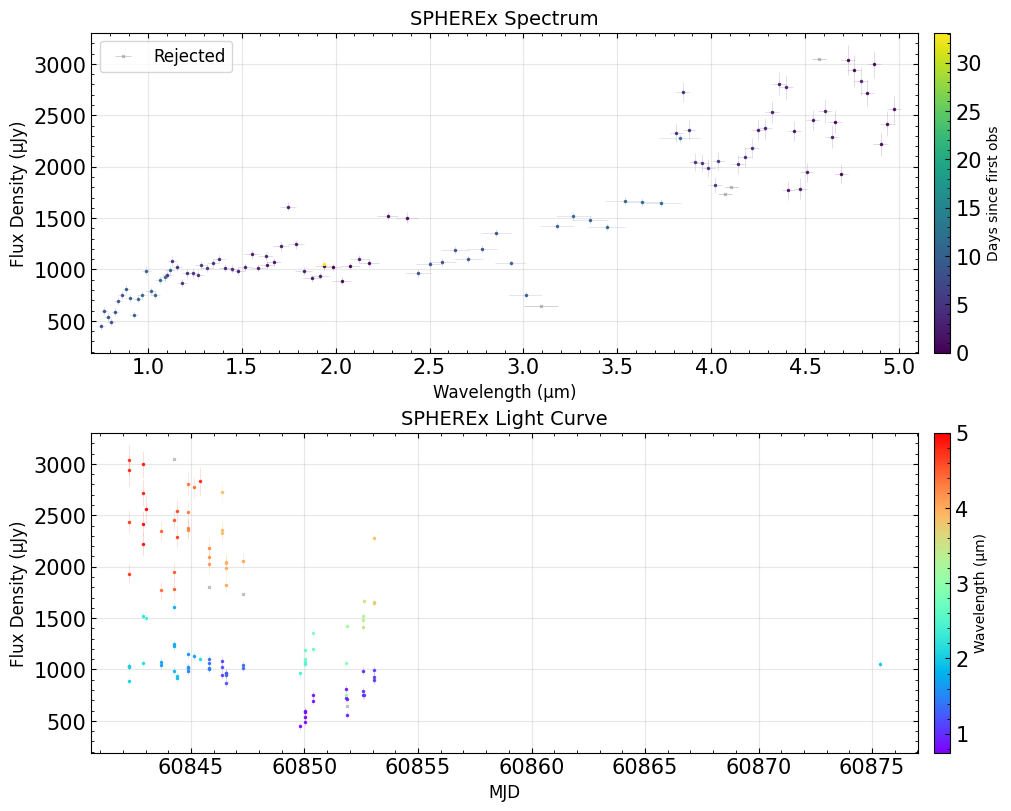

In [6]:
# Method 1: Using SPXQueryPipeline with advanced_params_file
print("\nMethod 1: Using SPXQueryPipeline with advanced_params_file")
print("=" * 70)

# Create source
pipeline_custom = SPXQueryPipeline(config_all)

# Verify parameters were loaded
print("\n✓ Custom parameters loaded!")
print(f"  Visualization DPI: {pipeline_custom.config.visualization.dpi}")
print(f"  Figure size: {pipeline_custom.config.visualization.figsize}")
print(f"  Wavelength colormap: {pipeline_custom.config.visualization.wavelength_cmap}")
print(f"  BG sigma clipping: {pipeline_custom.config.photometry.bg_sigma_clip_sigma}")

# Create and run pipeline
# Uncomment to run:
pipeline_custom.run_full_pipeline()

print("\nTo run pipeline, uncomment the last two lines above.")

2025-11-13 00:33:11 - spxquery.core.config - INFO - Loaded advanced parameters from demo_data/cloverleaf/config_params.yaml
2025-11-13 00:33:11 - spxquery.utils.params - INFO - Loaded advanced parameters from demo_data/cloverleaf/config_params.yaml
2025-11-13 00:33:11 - spxquery.core.pipeline - INFO - Initialized pipeline for source at RA=213.942708, Dec=11.495389
2025-11-13 00:33:11 - spxquery.core.pipeline - INFO - Pipeline stages: ['query', 'download', 'processing', 'visualization']
2025-11-13 00:33:11 - spxquery.core.pipeline - INFO - State file: cloverleaf.yaml
2025-11-13 00:33:11 - spxquery.core.pipeline - INFO - Starting full pipeline execution
2025-11-13 00:33:11 - spxquery.core.pipeline - INFO - Pipeline stages: ['query', 'download', 'processing', 'visualization']
2025-11-13 00:33:11 - spxquery.core.pipeline - INFO - Running query stage
2025-11-13 00:33:11 - spxquery.core.query - INFO - Querying SPHEREx observations for source at RA=213.942708, Dec=11.495389


Method 2: Using run_pipeline() with advanced_params_file


2025-11-13 00:33:37 - spxquery.core.query - INFO - Found 108 observations spanning 33.1 days
2025-11-13 00:33:37 - spxquery.core.pipeline - INFO - Marked stage 'query' as complete
2025-11-13 00:33:37 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=download, completed=['query']
2025-11-13 00:33:37 - spxquery.core.pipeline - INFO - Running download stage (skip_existing=True)
2025-11-13 00:33:37 - spxquery.core.download - INFO - Starting parallel download of 108 files
2025-11-13 00:33:37 - spxquery.core.download - INFO - Download settings: timeout=300s, retries=3, workers=4



SPHEREx Archive Search Results
Source: RA=213.942708, Dec=11.495389
        Name: cloverleaf
Query time: 2025-11-13 00:33:37

Total observations found: 108

Observations by band:
  D1 (0.75-1.09 μm):  18 observations
  D2 (1.10-1.62 μm):  18 observations
  D3 (1.63-2.41 μm):  18 observations
  D4 (2.42-3.82 μm):  18 observations
  D5 (3.83-4.41 μm):  18 observations
  D6 (4.42-5.00 μm):  18 observations

Time span: 33.1 days
Total data volume: 0.00 GB



Downloading:   0%|          | 0/108 [00:00<?, ?files/s]2025-11-13 00:33:37 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_1.fits - already exists
2025-11-13 00:33:37 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_1.fits - already exists
2025-11-13 00:33:37 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_2.fits - already exists
2025-11-13 00:33:37 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_2.fits - already exists
2025-11-13 00:33:37 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_3.fits - already exists
2025-11-13 00:33:37 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_3.fits - already exists
2025-11-13 00:33:37 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_4.fits - already exists
2025-11-13 00:33:37 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_4.fits - already exists
2025-11-13 00:33:37 - spxquery.core.download - INFO - Skipping 2025W25_1B_0178_1.fits - already exists
2025-11-13 00:33:3


Download Summary
Total files: 108
Successful: 108
Failed: 0
Total downloaded: 525.9 MB (0.51 GB)



Processing observations: 100%|██████████| 108/108 [00:02<00:00, 47.21files/s]
2025-11-13 00:33:39 - spxquery.processing.photometry - INFO - Successfully processed 108 observations
2025-11-13 00:33:39 - spxquery.processing.lightcurve - INFO - Generated light curve with 108 measurements
2025-11-13 00:33:39 - spxquery.processing.lightcurve - INFO - Saved light curve to demo_data/cloverleaf/results/lightcurve.csv
2025-11-13 00:33:39 - spxquery.core.pipeline - INFO - Marked stage 'processing' as complete
2025-11-13 00:33:39 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=visualization, completed=['query', 'download', 'processing']
2025-11-13 00:33:39 - spxquery.core.pipeline - INFO - Running visualization stage
2025-11-13 00:33:39 - spxquery.visualization.plots - INFO - Quality filtering: 108 total points (104 good, 4 rejected - shown as crosses)
2025-11-13 00:33:39 - spxquery.visualization.plots - INFO - Sigma clipping: 108 -> 107 measurements (1 outliers removed)
2025-11-13 


Light Curve Summary
Total observations: 108
Time span: 33.1 days
MJD range: 60842.27 - 60875.36
Wavelength range: 0.75 - 4.97 μm
Number of bands: 6
Upper limits: 0
Mean SNR: 25.3

Observations per band:
  D1: 18
  D2: 18
  D3: 18
  D4: 18
  D5: 18
  D6: 18



2025-11-13 00:33:39 - spxquery.visualization.plots - INFO - Saved combined plot to demo_data/cloverleaf/results/combined_plot.png
2025-11-13 00:33:39 - spxquery.core.pipeline - INFO - Marked stage 'visualization' as complete
2025-11-13 00:33:40 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=complete, completed=['query', 'download', 'processing', 'visualization']
2025-11-13 00:33:40 - spxquery.core.pipeline - INFO - Visualization saved to demo_data/cloverleaf/results/combined_plot.png
2025-11-13 00:33:40 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=complete, completed=['query', 'download', 'processing', 'visualization']
2025-11-13 00:33:40 - spxquery.core.pipeline - INFO - Pipeline execution complete


To run pipeline with custom parameters, uncomment the code above.
Custom parameters will be loaded from: demo_data/cloverleaf/config_params.yaml


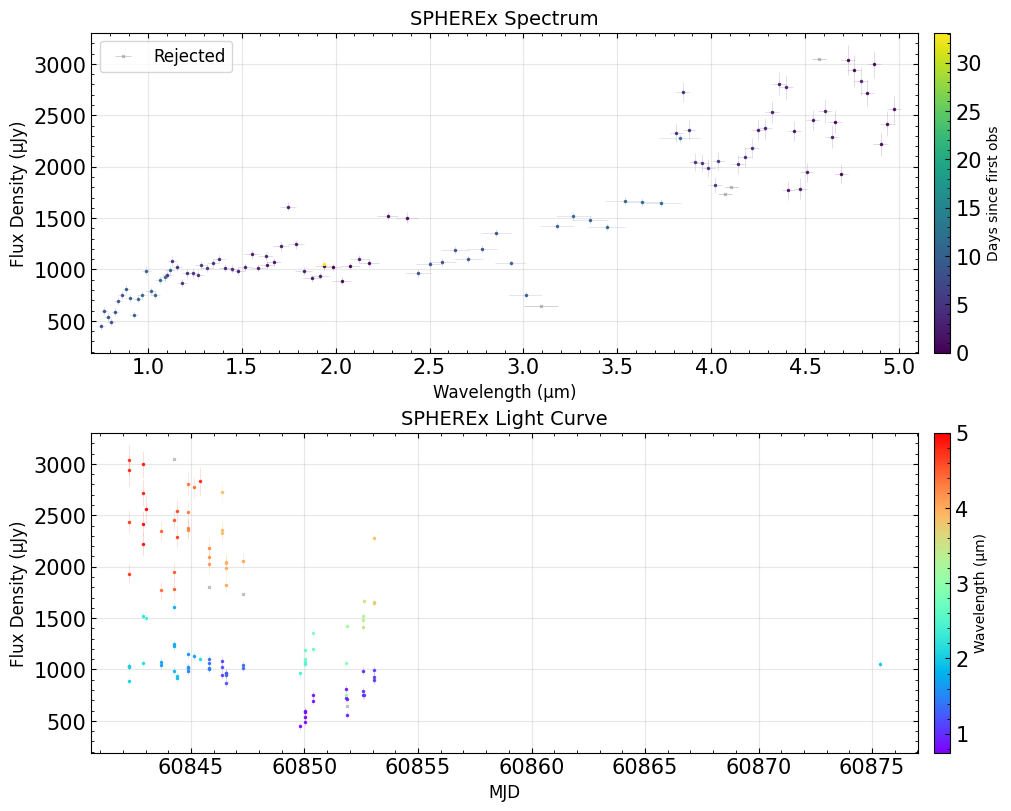

In [7]:
# Method 2: Using run_pipeline() function

# ======================================
# === Old way and will be deprecated ===
# ======================================

print("Method 2: Using run_pipeline() with advanced_params_file")
print("=" * 70)

run_pipeline(
    ra=213.9427080,
    dec=11.4953890,
    source_name="cloverleaf",
    output_dir=Path("demo_data/cloverleaf"),
    advanced_params_file=params_file,  # <-- Load custom parameters
)

print("To run pipeline with custom parameters, uncomment the code above.")
print(f"Custom parameters will be loaded from: {params_file}")

### Option A: One-Click Resume

The simplest way - let the pipeline automatically run all remaining stages.

In [8]:
# Uncomment to run one-click resume:
pipeline_resumed = SPXQueryPipeline(AdvancedConfig.from_yaml_file(output_dir / "cloverleaf.yaml"))
pipeline_resumed.resume(skip_existing_downloads=True)
print("\nFinal status after resume:")
pipeline_resumed.print_status()

print("To use one-click resume, uncomment the lines above.")
print("This will automatically complete all remaining stages.")

2025-11-13 00:33:40 - spxquery.core.config - INFO - Loaded advanced parameters from demo_data/cloverleaf/cloverleaf.yaml
2025-11-13 00:33:40 - spxquery.core.pipeline - INFO - Initialized pipeline for source at RA=213.942708, Dec=11.495389
2025-11-13 00:33:40 - spxquery.core.pipeline - INFO - Pipeline stages: ['query', 'download', 'processing', 'visualization']
2025-11-13 00:33:40 - spxquery.core.pipeline - INFO - State file: cloverleaf.yaml
2025-11-13 00:33:40 - spxquery.core.pipeline - INFO - Loaded pipeline state: stage=complete, completed=['query', 'download', 'processing', 'visualization']
2025-11-13 00:33:40 - spxquery.core.pipeline - INFO - Resuming from saved state
2025-11-13 00:33:40 - spxquery.core.pipeline - INFO - All stages already complete



Pipeline Status:
  Completed stages: ['query', 'download', 'processing', 'visualization']
  Pending stages: None
  Current stage: complete


Final status after resume:

Pipeline Status:
  Completed stages: ['query', 'download', 'processing', 'visualization']
  Pending stages: None
  Current stage: complete

To use one-click resume, uncomment the lines above.
This will automatically complete all remaining stages.


### Option B: Step-by-Step Manual Execution

Run each remaining stage manually for more control.

In [9]:
# Check what stages still need to be run
print("Checking which stages remain...")
print(f"\nCompleted stages: {pipeline_resumed.state.completed_stages}")
print(f"Pipeline stages: {pipeline_resumed.config.pipeline_stages}")

remaining = [s for s in pipeline_resumed.config.pipeline_stages if s not in pipeline_resumed.state.completed_stages]
print(f"\nRemaining stages: {remaining if remaining else 'None - all complete!'}")

print("\n✓ Pipeline stages now in AdvancedConfig (not PipelineState)")
print("  - No duplicate entries in YAML file")
print("  - Accessible via: pipeline.config.pipeline_stages")

Checking which stages remain...

Completed stages: ['query', 'download', 'processing', 'visualization']
Pipeline stages: ['query', 'download', 'processing', 'visualization']

Remaining stages: None - all complete!

✓ Pipeline stages now in AdvancedConfig (not PipelineState)
  - No duplicate entries in YAML file
  - Accessible via: pipeline.config.pipeline_stages


In [10]:
# Step 1: Download (if not already completed)
if "download" in pipeline_resumed.state.completed_stages:
    print("✓ Download stage already completed. Skipping.")
else:
    print("\nRunning download stage...")
    pipeline_resumed.run_download(skip_existing=True)
    print("\n✓ Download complete!")
    pipeline_resumed.print_status()

✓ Download stage already completed. Skipping.


In [11]:
# Step 2: Processing (if not already completed)
if "processing" in pipeline_resumed.state.completed_stages:
    print("✓ Processing stage already completed. Skipping.")
else:
    print("\nRunning processing stage...")
    pipeline_resumed.run_processing()
    print("\n✓ Processing complete!")
    pipeline_resumed.print_status()

✓ Processing stage already completed. Skipping.


In [12]:
# Step 3: Visualization (if not already completed)
if "visualization" in pipeline_resumed.state.completed_stages:
    print("✓ Visualization stage already completed. Skipping.")
else:
    print("\nRunning visualization stage...")
    pipeline_resumed.run_visualization()
    print("\n✓ Visualization complete!")
    pipeline_resumed.print_status()

print("\n" + "=" * 70)
print("ALL STAGES COMPLETE!")
print("=" * 70)

✓ Visualization stage already completed. Skipping.

ALL STAGES COMPLETE!


## View Results

After running the pipeline, results are saved in the output directory.


Light curve plot:


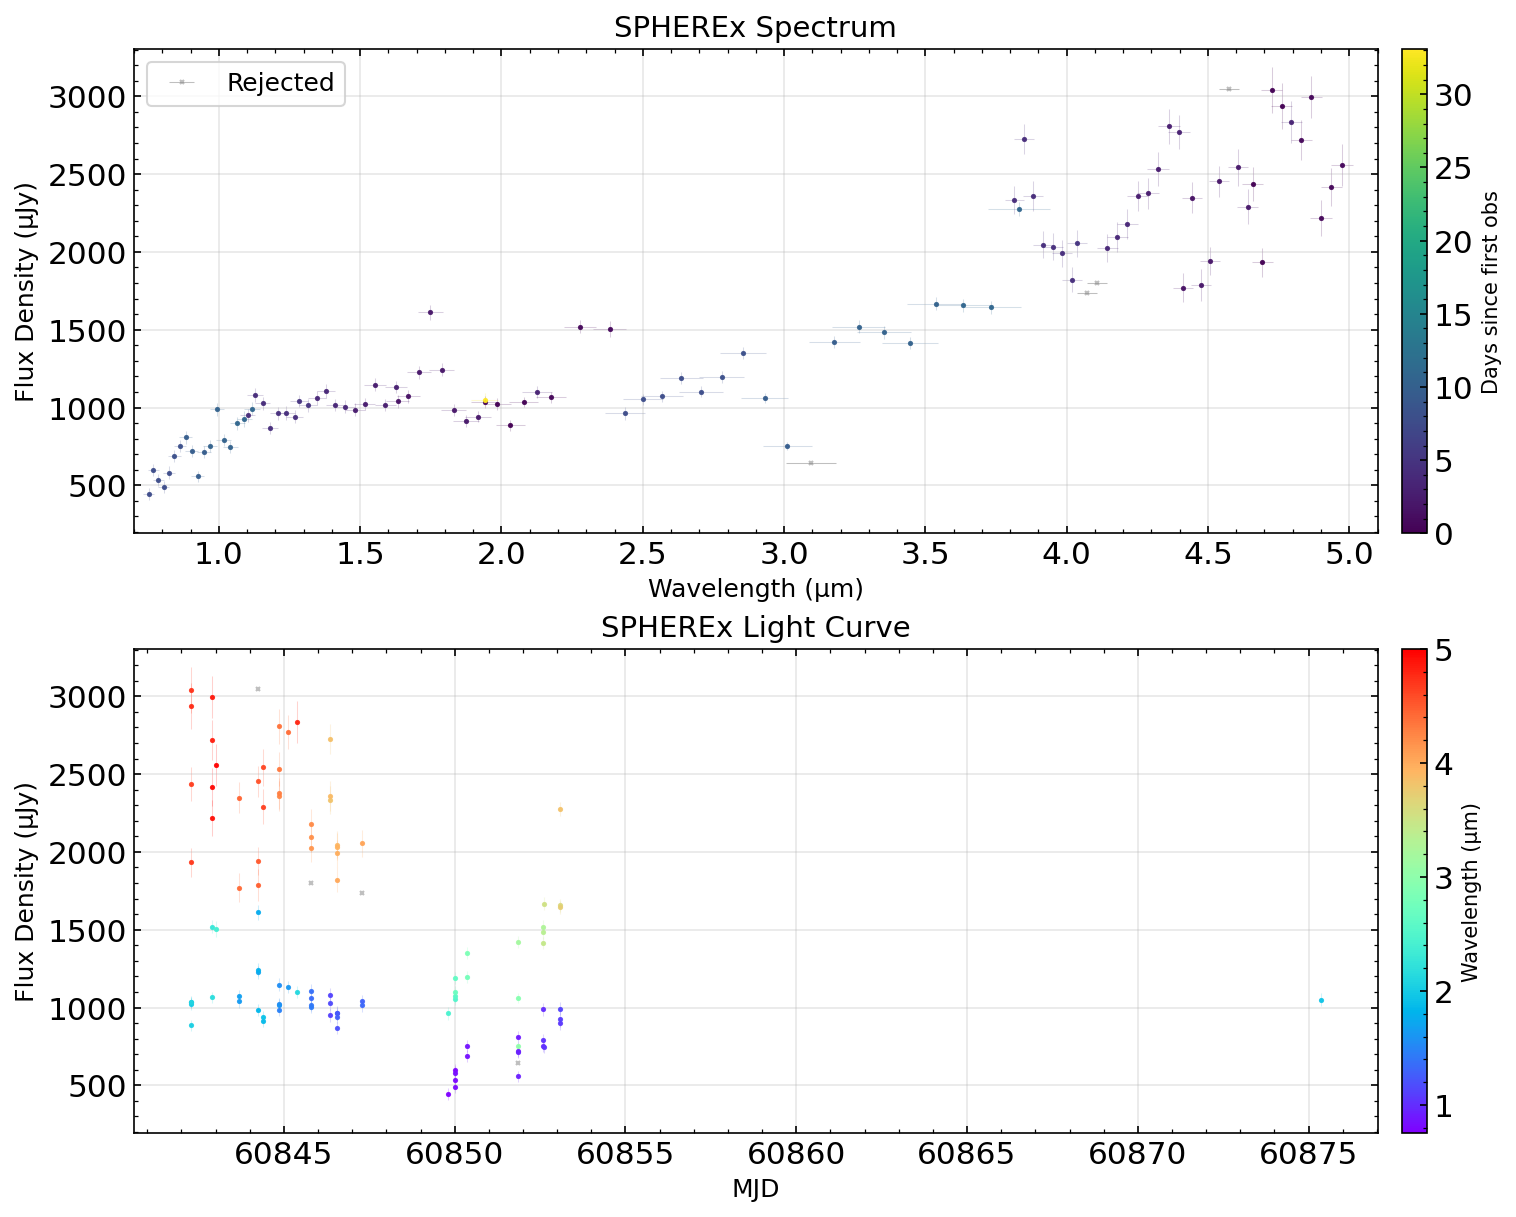

In [13]:
# Display the light curve plot
import pandas as pd
from IPython.display import Image, display

# Show plot from the one-click example
plot_path = output_dir / "results" / "combined_plot.png"
if plot_path.exists():
    print("\nLight curve plot:")
    display(Image(filename=str(plot_path)))
else:
    print(f"Plot not found at {plot_path}")

## Background and Aperture Method Comparison

In [14]:
# Display the light curve data
csv_path = output_dir / "results" / "lightcurve.csv"
if csv_path.exists():
    df = pd.read_csv(csv_path, comment="#")
    print("\nLight curve data (first 10 rows):")
    display(df.head(10))
    print(f"\nTotal measurements: {len(df)}")
else:
    print(f"CSV not found at {csv_path}")


Light curve data (first 10 rows):


,obs_id,mjd,flux,flux_error,mag_ab,mag_ab_error,wavelength,bandwidth,band,flag,flag_binary,pix_x,pix_y,is_upper_limit,snr
0,2025W25_1B_0062_1,60842.269794,1038.190806,38.594902,16.359307,0.040362,1.940270,0.047790,D3,2097152,1000000000000000000000,29.226040,29.946309,False,26.899687
1,2025W25_1B_0062_1,60842.269794,2436.806596,110.306551,15.432947,0.049148,4.658078,0.036448,D6,2097152,1000000000000000000000,29.557889,29.859574,False,22.091223
2,2025W25_1B_0062_2,60842.271286,1023.153740,37.410014,16.375148,0.039698,1.984936,0.048890,D3,2097152,1000000000000000000000,29.228793,29.049005,False,27.349729
3,2025W25_1B_0062_2,60842.271286,1933.090874,93.695601,15.684369,0.052625,4.691950,0.036713,D6,2097152,1000000000000000000000,29.420567,29.979960,False,20.631608
4,2025W25_1B_0062_3,60842.272779,886.621010,35.335209,16.530655,0.043271,2.031681,0.050041,D3,2097152,1000000000000000000000,29.779715,29.163495,False,25.091716
5,2025W25_1B_0062_3,60842.272779,3041.467188,146.377337,15.192292,0.052253,4.726364,0.036983,D6,2097152,1000000000000000000000,29.694355,29.330708,False,20.778266
6,2025W25_1B_0062_4,60842.274271,1035.728823,35.127564,16.361885,0.036824,2.078427,0.051193,D3,2097152,1000000000000000000000,29.027695,29.260076,False,29.484789
7,2025W25_1B_0062_4,60842.274271,2935.771804,149.228218,15.230694,0.055189,4.760819,0.037252,D6,2097152,1000000000000000000000,29.752959,29.544355,False,19.673034
8,2025W25_1B_0178_1,60842.882044,2720.236164,127.554061,15.313483,0.050911,4.830310,0.037796,D6,2097152,1000000000000000000000,29.663109,29.794504,False,21.326143
9,2025W25_1B_0178_1,60842.882044,1065.492761,36.851711,16.331124,0.037552,2.175510,0.053584,D3,2097152,1000000000000000000000,29.418622,29.210586,False,28.912979



Total measurements: 108


## Background Method Comparison (NEW in v0.2.1)

SPXQuery v0.2.1 introduces two methods for local background estimation:

### Annulus Method (Traditional)
- Uses an annular region around the source aperture
- Inner radius offset from aperture edge
- Outer radius determined by minimum area requirement
- Best for isolated sources in sparse fields

### Window Method (NEW)
- Uses a rectangular window centered on the source
- Automatically excludes pixels intersecting the aperture
- Simpler geometry, easier to visualize
- More robust in crowded fields or near image edges

Below we demonstrate both methods and compare their results.

### Recommendations

**When to use Annulus method:**
- Isolated point sources in sparse fields
- When local background varies smoothly
- Traditional aperture photometry workflows

**When to use Window method:**
- Crowded fields with nearby sources
- Sources near image edges or defects
- When you want simpler background geometry
- Faster computation (simpler geometry)

**Configuration tip:** Save your preferred method in a YAML template for consistent analysis!

In [15]:
# Setup: Create configurations for both background methods
from spxquery.core.config import PhotometryConfig, AdvancedConfig
import pandas as pd
import matplotlib.pyplot as plt

# Configuration with annulus background (default)
advanced_annulus = AdvancedConfig.from_yaml_file(output_dir / "cloverleaf.yaml")
advanced_annulus.update(
    aperture_method="fixed", aperture_diameter=2.0, background_method="annulus", annulus_inner_offset=1.414
)

# Configuration with window background (NEW)
advanced_window = AdvancedConfig.from_yaml_file(output_dir / "cloverleaf.yaml")
advanced_window.update(aperture_method="fixed", aperture_diameter=2.0, background_method="window", window_size=50)

print("✓ Configurations created:")
print(f"  Annulus: method={advanced_annulus.photometry.background_method}")
print(f"  Window: method={advanced_window.photometry.background_method}, size={advanced_window.photometry.window_size}")

2025-11-13 00:33:40 - spxquery.core.config - INFO - Loaded advanced parameters from demo_data/cloverleaf/cloverleaf.yaml
2025-11-13 00:33:40 - spxquery.core.config - INFO - Updated parameters: ['aperture_method', 'aperture_diameter', 'background_method', 'annulus_inner_offset']
2025-11-13 00:33:40 - spxquery.core.config - INFO - Loaded advanced parameters from demo_data/cloverleaf/cloverleaf.yaml
2025-11-13 00:33:40 - spxquery.core.config - INFO - Updated parameters: ['aperture_method', 'aperture_diameter', 'background_method', 'window_size']


✓ Configurations created:
  Annulus: method=annulus
  Window: method=window, size=50


2025-11-13 00:33:40 - spxquery.core.pipeline - INFO - Initialized pipeline for source at RA=213.942708, Dec=11.495389
2025-11-13 00:33:40 - spxquery.core.pipeline - INFO - Pipeline stages: ['query', 'download', 'processing', 'visualization']
2025-11-13 00:33:40 - spxquery.core.pipeline - INFO - State file: cloverleaf.yaml
2025-11-13 00:33:40 - spxquery.core.pipeline - INFO - Starting full pipeline execution
2025-11-13 00:33:40 - spxquery.core.pipeline - INFO - Pipeline stages: ['query', 'download', 'processing', 'visualization']
2025-11-13 00:33:40 - spxquery.core.pipeline - INFO - Running query stage
2025-11-13 00:33:40 - spxquery.core.query - INFO - Querying SPHEREx observations for source at RA=213.942708, Dec=11.495389
2025-11-13 00:33:46 - spxquery.core.query - INFO - Found 108 observations spanning 33.1 days
2025-11-13 00:33:46 - spxquery.core.pipeline - INFO - Marked stage 'query' as complete
2025-11-13 00:33:46 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=downl


SPHEREx Archive Search Results
Source: RA=213.942708, Dec=11.495389
        Name: cloverleaf
Query time: 2025-11-13 00:33:46

Total observations found: 108

Observations by band:
  D1 (0.75-1.09 μm):  18 observations
  D2 (1.10-1.62 μm):  18 observations
  D3 (1.63-2.41 μm):  18 observations
  D4 (2.42-3.82 μm):  18 observations
  D5 (3.83-4.41 μm):  18 observations
  D6 (4.42-5.00 μm):  18 observations

Time span: 33.1 days
Total data volume: 0.00 GB



Downloading:   0%|          | 0/108 [00:00<?, ?files/s]2025-11-13 00:33:46 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_1.fits - already exists
2025-11-13 00:33:46 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_1.fits - already exists
2025-11-13 00:33:46 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_2.fits - already exists
2025-11-13 00:33:46 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_2.fits - already exists
2025-11-13 00:33:46 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_3.fits - already exists
2025-11-13 00:33:46 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_3.fits - already exists
2025-11-13 00:33:46 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_4.fits - already exists
2025-11-13 00:33:46 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_4.fits - already exists
2025-11-13 00:33:46 - spxquery.core.download - INFO - Skipping 2025W25_1B_0178_1.fits - already exists
2025-11-13 00:33:4


Download Summary
Total files: 108
Successful: 108
Failed: 0
Total downloaded: 525.9 MB (0.51 GB)



Processing observations: 100%|██████████| 108/108 [00:01<00:00, 104.66files/s]
2025-11-13 00:33:47 - spxquery.processing.photometry - INFO - Successfully processed 108 observations
2025-11-13 00:33:47 - spxquery.processing.lightcurve - INFO - Generated light curve with 108 measurements
2025-11-13 00:33:47 - spxquery.processing.lightcurve - INFO - Saved light curve to demo_data/cloverleaf/results/lightcurve.csv
2025-11-13 00:33:47 - spxquery.core.pipeline - INFO - Marked stage 'processing' as complete
2025-11-13 00:33:47 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=visualization, completed=['query', 'download', 'processing']
2025-11-13 00:33:47 - spxquery.core.pipeline - INFO - Running visualization stage
2025-11-13 00:33:47 - spxquery.visualization.plots - INFO - Quality filtering: 108 total points (105 good, 3 rejected - shown as crosses)
2025-11-13 00:33:47 - spxquery.visualization.plots - INFO - Sigma clipping: 108 -> 107 measurements (1 outliers removed)
2025-11-13


Light Curve Summary
Total observations: 108
Time span: 33.1 days
MJD range: 60842.27 - 60875.36
Wavelength range: 0.75 - 4.97 μm
Number of bands: 6
Upper limits: 0
Mean SNR: 25.4

Observations per band:
  D1: 18
  D2: 18
  D3: 18
  D4: 18
  D5: 18
  D6: 18



2025-11-13 00:33:47 - spxquery.visualization.plots - INFO - Saved combined plot to demo_data/cloverleaf/results/combined_plot.png
2025-11-13 00:33:47 - spxquery.core.pipeline - INFO - Marked stage 'visualization' as complete
2025-11-13 00:33:47 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=complete, completed=['query', 'download', 'processing', 'visualization']
2025-11-13 00:33:47 - spxquery.core.pipeline - INFO - Visualization saved to demo_data/cloverleaf/results/combined_plot.png
2025-11-13 00:33:47 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=complete, completed=['query', 'download', 'processing', 'visualization']
2025-11-13 00:33:47 - spxquery.core.pipeline - INFO - Pipeline execution complete


Annulus method configuration ready.
Uncomment the code above to run the pipeline.


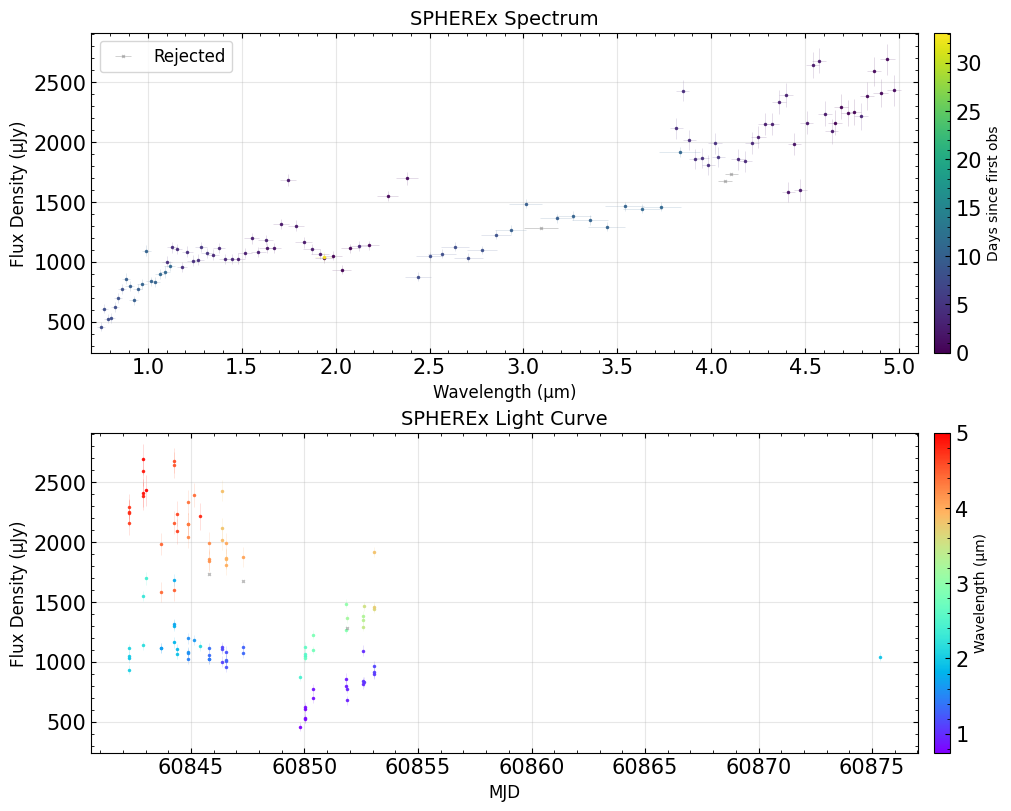

In [16]:
# Demo 1: Run pipeline with annulus background
config_annulus = SPXQueryPipeline(advanced_annulus)
config_annulus.run_full_pipeline(skip_existing_downloads=True)
df_annulus = pd.read_csv(output_dir / "results/lightcurve.csv", comment="#")
print("Annulus method configuration ready.")
print("Uncomment the code above to run the pipeline.")

2025-11-13 00:33:48 - spxquery.core.pipeline - INFO - Initialized pipeline for source at RA=213.942708, Dec=11.495389
2025-11-13 00:33:48 - spxquery.core.pipeline - INFO - Pipeline stages: ['query', 'download', 'processing', 'visualization']
2025-11-13 00:33:48 - spxquery.core.pipeline - INFO - State file: cloverleaf.yaml
2025-11-13 00:33:48 - spxquery.core.pipeline - INFO - Starting full pipeline execution
2025-11-13 00:33:48 - spxquery.core.pipeline - INFO - Pipeline stages: ['query', 'download', 'processing', 'visualization']
2025-11-13 00:33:48 - spxquery.core.pipeline - INFO - Running query stage
2025-11-13 00:33:48 - spxquery.core.query - INFO - Querying SPHEREx observations for source at RA=213.942708, Dec=11.495389
2025-11-13 00:33:52 - spxquery.core.query - INFO - Found 108 observations spanning 33.1 days
2025-11-13 00:33:52 - spxquery.core.pipeline - INFO - Marked stage 'query' as complete
2025-11-13 00:33:52 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=downl


SPHEREx Archive Search Results
Source: RA=213.942708, Dec=11.495389
        Name: cloverleaf
Query time: 2025-11-13 00:33:52

Total observations found: 108

Observations by band:
  D1 (0.75-1.09 μm):  18 observations
  D2 (1.10-1.62 μm):  18 observations
  D3 (1.63-2.41 μm):  18 observations
  D4 (2.42-3.82 μm):  18 observations
  D5 (3.83-4.41 μm):  18 observations
  D6 (4.42-5.00 μm):  18 observations

Time span: 33.1 days
Total data volume: 0.00 GB



Downloading:   0%|          | 0/108 [00:00<?, ?files/s]2025-11-13 00:33:52 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_1.fits - already exists
2025-11-13 00:33:52 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_1.fits - already exists
2025-11-13 00:33:52 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_2.fits - already exists
2025-11-13 00:33:52 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_2.fits - already exists
2025-11-13 00:33:52 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_3.fits - already exists
2025-11-13 00:33:52 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_3.fits - already exists
2025-11-13 00:33:52 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_4.fits - already exists
2025-11-13 00:33:52 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_4.fits - already exists
2025-11-13 00:33:52 - spxquery.core.download - INFO - Skipping 2025W25_1B_0178_1.fits - already exists
2025-11-13 00:33:5


Download Summary
Total files: 108
Successful: 108
Failed: 0
Total downloaded: 525.9 MB (0.51 GB)



Processing observations: 100%|██████████| 108/108 [00:00<00:00, 111.76files/s]
2025-11-13 00:33:53 - spxquery.processing.photometry - INFO - Successfully processed 108 observations
2025-11-13 00:33:53 - spxquery.processing.lightcurve - INFO - Generated light curve with 108 measurements
2025-11-13 00:33:53 - spxquery.processing.lightcurve - INFO - Saved light curve to demo_data/cloverleaf/results/lightcurve.csv
2025-11-13 00:33:53 - spxquery.core.pipeline - INFO - Marked stage 'processing' as complete
2025-11-13 00:33:53 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=visualization, completed=['query', 'download', 'processing']
2025-11-13 00:33:53 - spxquery.core.pipeline - INFO - Running visualization stage
2025-11-13 00:33:53 - spxquery.visualization.plots - INFO - Quality filtering: 108 total points (105 good, 3 rejected - shown as crosses)
2025-11-13 00:33:53 - spxquery.visualization.plots - INFO - Sigma clipping: 108 -> 107 measurements (1 outliers removed)
2025-11-13


Light Curve Summary
Total observations: 108
Time span: 33.1 days
MJD range: 60842.27 - 60875.36
Wavelength range: 0.75 - 4.97 μm
Number of bands: 6
Upper limits: 0
Mean SNR: 26.2

Observations per band:
  D1: 18
  D2: 18
  D3: 18
  D4: 18
  D5: 18
  D6: 18



2025-11-13 00:33:53 - spxquery.visualization.plots - INFO - Saved combined plot to demo_data/cloverleaf/results/combined_plot.png
2025-11-13 00:33:53 - spxquery.core.pipeline - INFO - Marked stage 'visualization' as complete
2025-11-13 00:33:53 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=complete, completed=['query', 'download', 'processing', 'visualization']
2025-11-13 00:33:53 - spxquery.core.pipeline - INFO - Visualization saved to demo_data/cloverleaf/results/combined_plot.png
2025-11-13 00:33:53 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=complete, completed=['query', 'download', 'processing', 'visualization']
2025-11-13 00:33:53 - spxquery.core.pipeline - INFO - Pipeline execution complete


Window method configuration ready.
Uncomment the code above to run the pipeline.


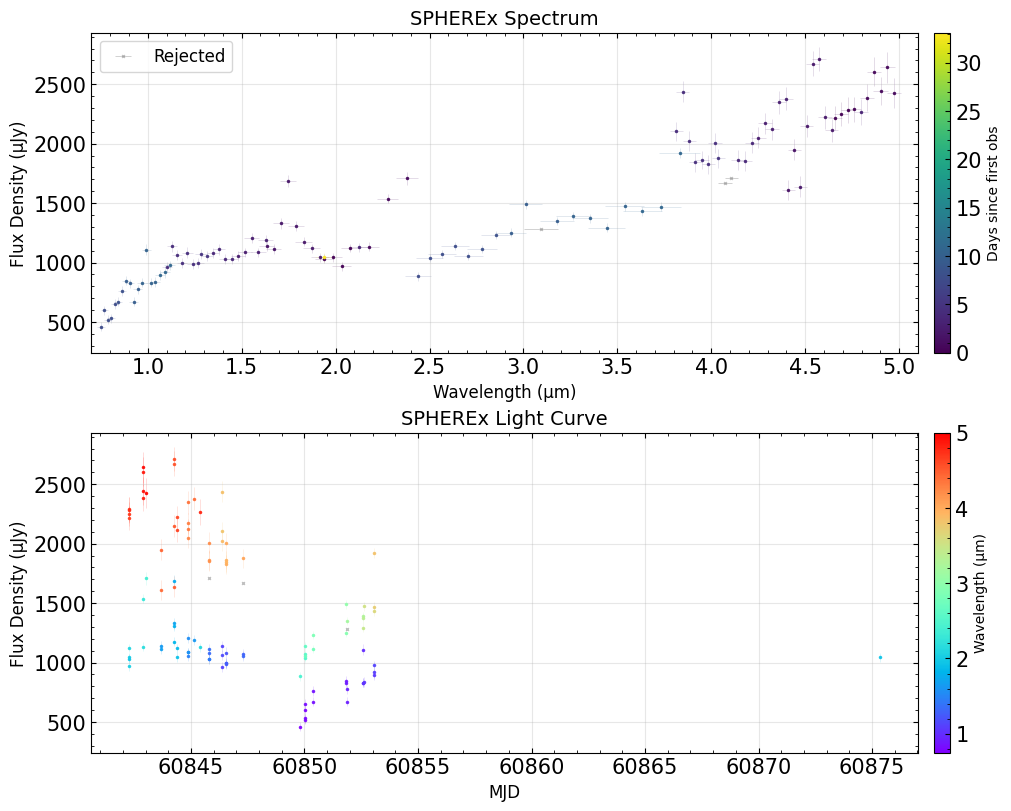

In [17]:
# Demo 2: Run pipeline with window background
config_window = SPXQueryPipeline(advanced_window)
config_window.run_full_pipeline(skip_existing_downloads=True)
df_window = pd.read_csv(output_dir / "results/lightcurve.csv", comment="#")
print("Window method configuration ready.")
print("Uncomment the code above to run the pipeline.")

/var/folders/z5/qygyj_xj7dq109c9rzqq2wv40000gn/T/ipykernel_78266/1917494619.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


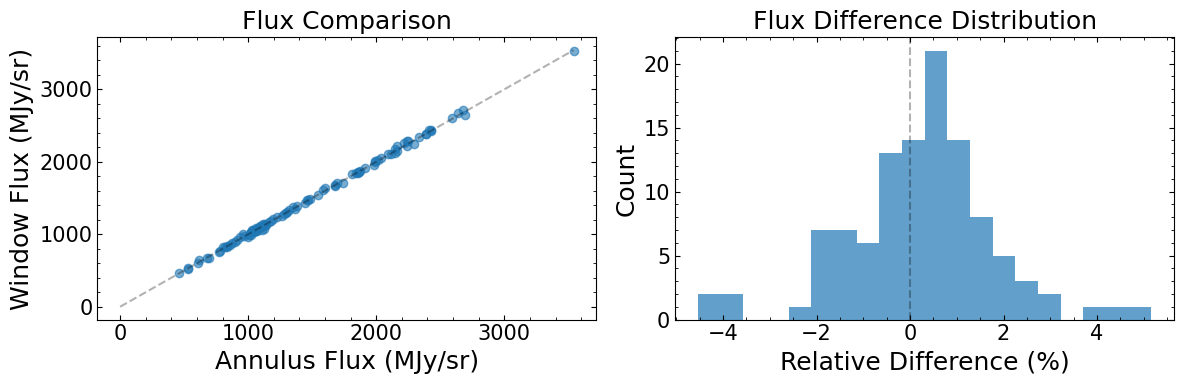

Mean flux difference: 0.22%
Std flux difference: 1.57%


In [18]:
# Compare flux measurements
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Flux comparison
axes[0].scatter(df_annulus["flux"], df_window["flux"], alpha=0.6)
axes[0].plot([0, max(df_annulus["flux"])], [0, max(df_annulus["flux"])], "k--", alpha=0.3)
axes[0].set_xlabel("Annulus Flux (MJy/sr)")
axes[0].set_ylabel("Window Flux (MJy/sr)")
axes[0].set_title("Flux Comparison")

# Plot 2: Difference
flux_diff = (df_window["flux"] - df_annulus["flux"]) / df_annulus["flux"] * 100
axes[1].hist(flux_diff, bins=20, alpha=0.7)
axes[1].set_xlabel("Relative Difference (%)")
axes[1].set_ylabel("Count")
axes[1].set_title("Flux Difference Distribution")
axes[1].axvline(0, color="k", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean flux difference: {flux_diff.mean():.2f}%")
print(f"Std flux difference: {flux_diff.std():.2f}%")

## Aperture Sizing Comparison (NEW in v0.2.1)

SPXQuery v0.2.1 introduces adaptive aperture sizing based on PSF FWHM:

### Fixed Aperture (Traditional)
- User specifies aperture diameter in pixels
- Same aperture size for all observations
- Simple, predictable, widely used
- May be suboptimal when seeing varies

### FWHM-Based Aperture (NEW)
- Aperture size adapts to PSF FWHM for each observation
- `aperture_diameter = FWHM × fwhm_multiplier`
- Optimizes signal-to-noise ratio
- Automatically falls back to fixed aperture if FWHM estimation fails

Below we demonstrate both methods and compare their photometric results.

In [19]:
# Setup: Create configurations for both aperture methods

# Configuration with fixed aperture (traditional)
advanced_fixed = AdvancedConfig.from_yaml_file(output_dir / "cloverleaf.yaml")
advanced_fixed.update(aperture_method="fixed", aperture_diameter=3.0, background_method="window", window_size=50)

# Configuration with FWHM-based aperture (NEW)
advanced_fwhm = AdvancedConfig.from_yaml_file(output_dir / "cloverleaf.yaml")
advanced_fwhm.update(
    aperture_method="fwhm",
    fwhm_multiplier=3.0,
    aperture_diameter=3.0,
    background_method="window",
    window_size=50,
    max_processing_workers=1,
)


print("✓ Configurations created:")
print(
    f"  Fixed: method={advanced_fixed.photometry.aperture_method}, diameter={advanced_fixed.photometry.aperture_diameter}"
)
print(
    f"  FWHM: method={advanced_fwhm.photometry.aperture_method}, multiplier={advanced_fwhm.photometry.fwhm_multiplier}"
)

2025-11-13 00:33:54 - spxquery.core.config - INFO - Loaded advanced parameters from demo_data/cloverleaf/cloverleaf.yaml
2025-11-13 00:33:54 - spxquery.core.config - INFO - Updated parameters: ['aperture_method', 'aperture_diameter', 'background_method', 'window_size']
2025-11-13 00:33:54 - spxquery.core.config - INFO - Loaded advanced parameters from demo_data/cloverleaf/cloverleaf.yaml
2025-11-13 00:33:54 - spxquery.core.config - INFO - Updated parameters: ['aperture_method', 'fwhm_multiplier', 'aperture_diameter', 'background_method', 'window_size', 'max_processing_workers']


✓ Configurations created:
  Fixed: method=fixed, diameter=3.0
  FWHM: method=fwhm, multiplier=3.0


2025-11-13 00:33:54 - spxquery.core.pipeline - INFO - Initialized pipeline for source at RA=213.942708, Dec=11.495389
2025-11-13 00:33:54 - spxquery.core.pipeline - INFO - Pipeline stages: ['query', 'download', 'processing', 'visualization']
2025-11-13 00:33:54 - spxquery.core.pipeline - INFO - State file: cloverleaf.yaml
2025-11-13 00:33:54 - spxquery.core.pipeline - INFO - Starting full pipeline execution
2025-11-13 00:33:54 - spxquery.core.pipeline - INFO - Pipeline stages: ['query', 'download', 'processing', 'visualization']
2025-11-13 00:33:54 - spxquery.core.pipeline - INFO - Running query stage
2025-11-13 00:33:54 - spxquery.core.query - INFO - Querying SPHEREx observations for source at RA=213.942708, Dec=11.495389
2025-11-13 00:33:58 - spxquery.core.query - INFO - Found 108 observations spanning 33.1 days
2025-11-13 00:33:58 - spxquery.core.pipeline - INFO - Marked stage 'query' as complete
2025-11-13 00:33:58 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=downl


SPHEREx Archive Search Results
Source: RA=213.942708, Dec=11.495389
        Name: cloverleaf
Query time: 2025-11-13 00:33:58

Total observations found: 108

Observations by band:
  D1 (0.75-1.09 μm):  18 observations
  D2 (1.10-1.62 μm):  18 observations
  D3 (1.63-2.41 μm):  18 observations
  D4 (2.42-3.82 μm):  18 observations
  D5 (3.83-4.41 μm):  18 observations
  D6 (4.42-5.00 μm):  18 observations

Time span: 33.1 days
Total data volume: 0.00 GB



Downloading:   0%|          | 0/108 [00:00<?, ?files/s]2025-11-13 00:33:58 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_1.fits - already exists
2025-11-13 00:33:58 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_1.fits - already exists
2025-11-13 00:33:58 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_2.fits - already exists
2025-11-13 00:33:58 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_2.fits - already exists
2025-11-13 00:33:58 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_3.fits - already exists
2025-11-13 00:33:58 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_3.fits - already exists
2025-11-13 00:33:58 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_4.fits - already exists
2025-11-13 00:33:58 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_4.fits - already exists
2025-11-13 00:33:58 - spxquery.core.download - INFO - Skipping 2025W25_1B_0178_1.fits - already exists
2025-11-13 00:33:5


Download Summary
Total files: 108
Successful: 108
Failed: 0
Total downloaded: 525.9 MB (0.51 GB)



Processing observations: 100%|██████████| 108/108 [00:00<00:00, 110.79files/s]
2025-11-13 00:33:59 - spxquery.processing.photometry - INFO - Successfully processed 108 observations
2025-11-13 00:33:59 - spxquery.processing.lightcurve - INFO - Generated light curve with 108 measurements
2025-11-13 00:33:59 - spxquery.processing.lightcurve - INFO - Saved light curve to demo_data/cloverleaf/results/lightcurve.csv
2025-11-13 00:33:59 - spxquery.core.pipeline - INFO - Marked stage 'processing' as complete
2025-11-13 00:33:59 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=visualization, completed=['query', 'download', 'processing']
2025-11-13 00:33:59 - spxquery.core.pipeline - INFO - Running visualization stage
2025-11-13 00:33:59 - spxquery.visualization.plots - INFO - Quality filtering: 108 total points (101 good, 7 rejected - shown as crosses)
2025-11-13 00:33:59 - spxquery.visualization.plots - INFO - Sigma clipping: 108 -> 107 measurements (1 outliers removed)
2025-11-13


Light Curve Summary
Total observations: 108
Time span: 33.1 days
MJD range: 60842.27 - 60875.36
Wavelength range: 0.75 - 4.97 μm
Number of bands: 6
Upper limits: 0
Mean SNR: 27.0

Observations per band:
  D1: 18
  D2: 18
  D3: 18
  D4: 18
  D5: 18
  D6: 18



2025-11-13 00:34:00 - spxquery.visualization.plots - INFO - Saved combined plot to demo_data/cloverleaf/results/combined_plot.png
2025-11-13 00:34:00 - spxquery.core.pipeline - INFO - Marked stage 'visualization' as complete
2025-11-13 00:34:00 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=complete, completed=['query', 'download', 'processing', 'visualization']
2025-11-13 00:34:00 - spxquery.core.pipeline - INFO - Visualization saved to demo_data/cloverleaf/results/combined_plot.png
2025-11-13 00:34:00 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=complete, completed=['query', 'download', 'processing', 'visualization']
2025-11-13 00:34:00 - spxquery.core.pipeline - INFO - Pipeline execution complete


Fixed aperture configuration ready.
  Aperture diameter: 3.0 pixels (constant)
Uncomment the code above to run the pipeline.


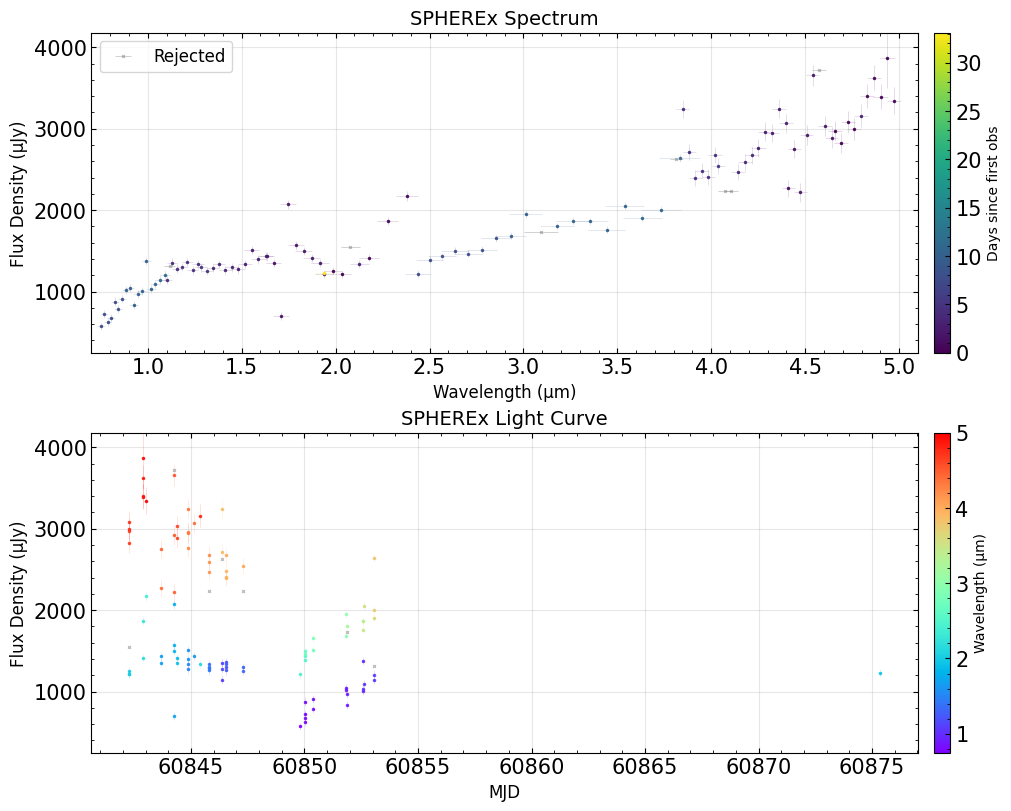

In [20]:
# Demo 1: Run pipeline with fixed aperture
config_fixed = SPXQueryPipeline(advanced_fixed)
config_fixed.run_full_pipeline(skip_existing_downloads=True)
df_fixed = pd.read_csv(output_dir / "results/lightcurve.csv", comment="#")

print("Fixed aperture configuration ready.")
print(f"  Aperture diameter: {advanced_fixed.photometry.aperture_diameter} pixels (constant)")
print("Uncomment the code above to run the pipeline.")

2025-11-13 00:34:00 - spxquery.core.pipeline - INFO - Initialized pipeline for source at RA=213.942708, Dec=11.495389
2025-11-13 00:34:00 - spxquery.core.pipeline - INFO - Pipeline stages: ['query', 'download', 'processing', 'visualization']
2025-11-13 00:34:00 - spxquery.core.pipeline - INFO - State file: cloverleaf.yaml
2025-11-13 00:34:00 - spxquery.core.pipeline - INFO - Starting full pipeline execution
2025-11-13 00:34:00 - spxquery.core.pipeline - INFO - Pipeline stages: ['query', 'download', 'processing', 'visualization']
2025-11-13 00:34:00 - spxquery.core.pipeline - INFO - Running query stage
2025-11-13 00:34:00 - spxquery.core.query - INFO - Querying SPHEREx observations for source at RA=213.942708, Dec=11.495389
2025-11-13 00:34:04 - spxquery.core.query - INFO - Found 108 observations spanning 33.1 days
2025-11-13 00:34:04 - spxquery.core.pipeline - INFO - Marked stage 'query' as complete
2025-11-13 00:34:04 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=downl


SPHEREx Archive Search Results
Source: RA=213.942708, Dec=11.495389
        Name: cloverleaf
Query time: 2025-11-13 00:34:04

Total observations found: 108

Observations by band:
  D1 (0.75-1.09 μm):  18 observations
  D2 (1.10-1.62 μm):  18 observations
  D3 (1.63-2.41 μm):  18 observations
  D4 (2.42-3.82 μm):  18 observations
  D5 (3.83-4.41 μm):  18 observations
  D6 (4.42-5.00 μm):  18 observations

Time span: 33.1 days
Total data volume: 0.00 GB



Downloading:   0%|          | 0/108 [00:00<?, ?files/s]2025-11-13 00:34:04 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_1.fits - already exists
2025-11-13 00:34:04 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_1.fits - already exists
2025-11-13 00:34:04 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_2.fits - already exists
2025-11-13 00:34:04 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_2.fits - already exists
2025-11-13 00:34:04 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_3.fits - already exists
2025-11-13 00:34:04 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_3.fits - already exists
2025-11-13 00:34:04 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_4.fits - already exists
2025-11-13 00:34:04 - spxquery.core.download - INFO - Skipping 2025W25_1B_0062_4.fits - already exists
2025-11-13 00:34:04 - spxquery.core.download - INFO - Skipping 2025W25_1B_0178_1.fits - already exists
2025-11-13 00:34:0


Download Summary
Total files: 108
Successful: 108
Failed: 0
Total downloaded: 525.9 MB (0.51 GB)



Processing observations:   0%|          | 0/108 [00:00<?, ?files/s]2025-11-13 00:34:04 - spxquery.utils.spherex_mef - INFO - Reading SPHEREx MEF: demo_data/cloverleaf/data/D3/2025W25_1B_0062_1.fits
2025-11-13 00:34:04 - spxquery.utils.spherex_mef - INFO - Converted units: MJy/sr → μJy/arcsec² (factor: 2.350443e+01)
2025-11-13 00:34:04 - spxquery.utils.spherex_mef - INFO - Loaded 2025W25_1B_0062_1: detector 3, shape (60, 60), units μJy/arcsec²
2025-11-13 00:34:04 - spxquery.processing.photometry - INFO - Repaired 12 pixels with NaN variance using median variance (9.499758e-02). All repaired pixels have non-zero flags.
2025-11-13 00:34:04 - spxquery.processing.photometry - INFO - FWHM-based aperture: FWHM=5.017" (0.82px) → diameter=2.45px (radius=1.22px)
2025-11-13 00:34:04 - spxquery.utils.spherex_mef - INFO - Background mask: 2663/3600 (74.0%) pixels available
2025-11-13 00:34:04 - spxquery.utils.spherex_mef - INFO - Zodiacal scaling factor: 1.1757
2025-11-13 00:34:04 - spxquery.utils.


Light Curve Summary
Total observations: 108
Time span: 33.1 days
MJD range: 60842.27 - 60875.36
Wavelength range: 0.75 - 4.97 μm
Number of bands: 6
Upper limits: 0
Mean SNR: 27.2

Observations per band:
  D1: 18
  D2: 18
  D3: 18
  D4: 18
  D5: 18
  D6: 18



2025-11-13 00:34:10 - spxquery.visualization.plots - INFO - Saved combined plot to demo_data/cloverleaf/results/combined_plot.png
2025-11-13 00:34:10 - spxquery.core.pipeline - INFO - Marked stage 'visualization' as complete
2025-11-13 00:34:10 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=complete, completed=['query', 'download', 'processing', 'visualization']
2025-11-13 00:34:10 - spxquery.core.pipeline - INFO - Visualization saved to demo_data/cloverleaf/results/combined_plot.png
2025-11-13 00:34:10 - spxquery.core.pipeline - INFO - Saved pipeline state: stage=complete, completed=['query', 'download', 'processing', 'visualization']
2025-11-13 00:34:10 - spxquery.core.pipeline - INFO - Pipeline execution complete


FWHM-based aperture configuration ready.
  Aperture = FWHM × 3.0 (adaptive per observation)
  Fallback diameter: 3.0 pixels
Uncomment the code above to run the pipeline.


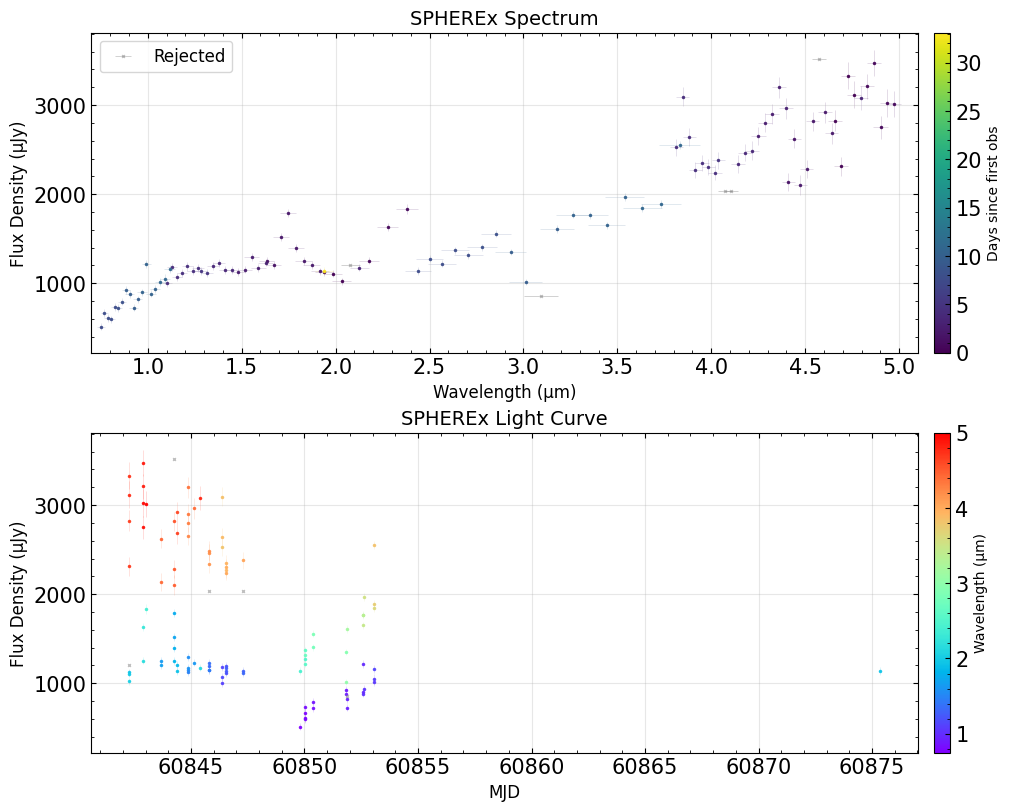

In [21]:
# Demo 2: Run pipeline with FWHM-based aperture
config_fwhm = SPXQueryPipeline(advanced_fwhm)
config_fwhm.run_full_pipeline(skip_existing_downloads=True)
df_fwhm = pd.read_csv(output_dir / "results/lightcurve.csv", comment="#")

print("FWHM-based aperture configuration ready.")
print(f"  Aperture = FWHM × {advanced_fwhm.photometry.fwhm_multiplier} (adaptive per observation)")
print(f"  Fallback diameter: {advanced_fwhm.photometry.aperture_diameter} pixels")
print("Uncomment the code above to run the pipeline.")

/var/folders/z5/qygyj_xj7dq109c9rzqq2wv40000gn/T/ipykernel_78266/2193692466.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


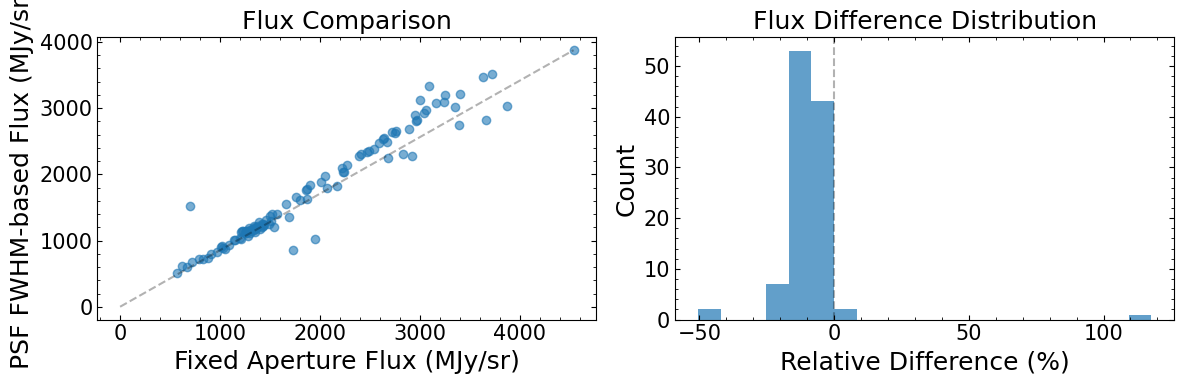

Mean flux difference: -9.35%
Std flux difference: 14.48%


In [22]:
# Compare flux measurements
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Flux comparison
axes[0].scatter(df_fixed["flux"], df_fwhm["flux"], alpha=0.6)
axes[0].plot([0, max(df_fixed["flux"])], [0, max(df_fwhm["flux"])], "k--", alpha=0.3)
axes[0].set_xlabel("Fixed Aperture Flux (MJy/sr)")
axes[0].set_ylabel("PSF FWHM-based Flux (MJy/sr)")
axes[0].set_title("Flux Comparison")

# Plot 2: Difference
flux_diff = (df_fwhm["flux"] - df_fixed["flux"]) / df_fixed["flux"] * 100
axes[1].hist(flux_diff, bins=20, alpha=0.7)
axes[1].set_xlabel("Relative Difference (%)")
axes[1].set_ylabel("Count")
axes[1].set_title("Flux Difference Distribution")
axes[1].axvline(0, color="k", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean flux difference: {flux_diff.mean():.2f}%")
print(f"Std flux difference: {flux_diff.std():.2f}%")


/var/folders/z5/qygyj_xj7dq109c9rzqq2wv40000gn/T/ipykernel_78266/3065869908.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


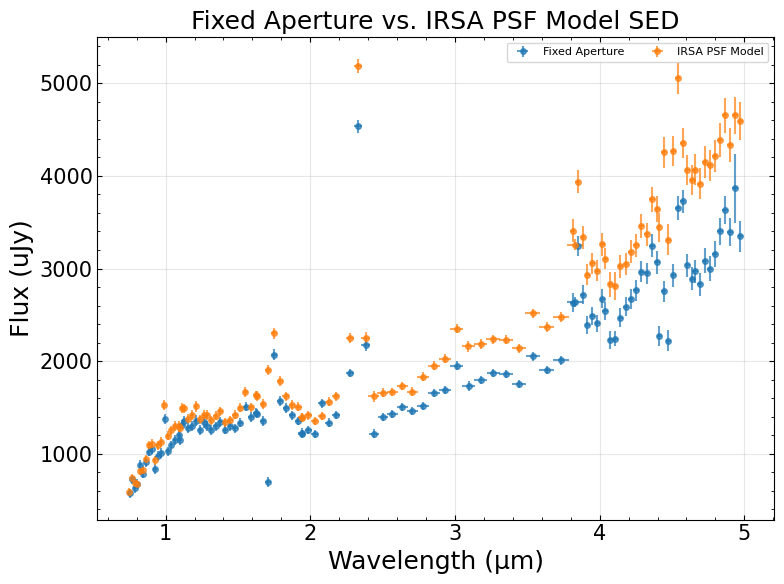

In [23]:
irsa = pd.read_csv(output_dir / "cloverleaf_irsa.csv")
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(
    df_fixed["wavelength"],
    df_fixed["flux"],
    yerr=df_fixed["flux_error"],
    xerr=df_fixed["bandwidth"] / 2,
    fmt="o",
    alpha=0.7,
    markersize=4,
    label="Fixed Aperture",
)

ax.errorbar(
    irsa["lambda"],
    irsa["flux"],
    yerr=irsa["flux_err"],
    xerr=irsa["lambda_width"] / 2,
    fmt="o",
    alpha=0.7,
    markersize=4,
    label="IRSA PSF Model",
)

ax.set_xlabel("Wavelength (μm)")
ax.set_ylabel("Flux (uJy)")
ax.set_title("Fixed Aperture vs. IRSA PSF Model SED")
ax.legend(ncol=6, fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# # Create spectral comparison plot with shared y-axis limits
# fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)

# # Calculate shared y-axis limits based on both datasets
# all_flux = pd.concat([df_fixed["flux"], df_fwhm["flux"]])
# all_flux_err = pd.concat([df_fixed["flux_error"], df_fwhm["flux_error"]])
# ymin = (all_flux - all_flux_err).min() * 0.9
# ymax = (all_flux + all_flux_err).max() * 1.1

# # Plot 1: Fixed aperture SED
# axes[0].errorbar(
#     df_fixed["wavelength"],
#     df_fixed["flux"],
#     yerr=df_fixed["flux_error"],
#     xerr=df_fixed["bandwidth"] / 2,
#     fmt="o",
#     alpha=0.7,
#     markersize=4,
# )
# axes[0].set_ylabel("Flux (uJy)")
# axes[0].set_title("Fixed Aperture SED")
# axes[0].legend(ncol=6, fontsize=8)
# axes[0].grid(True, alpha=0.3)

# # Plot 2: FWHM-based aperture SED
# irsa = pd.read_csv(output_dir / "cloverleaf_irsa.csv")
# axes[1].errorbar(
#     irsa["lambda"],
#     irsa["flux"],
#     yerr=irsa["flux_err"],
#     xerr=irsa["lambda_width"] / 2,
#     fmt="o",
#     alpha=0.7,
#     markersize=4,
# )
# axes[1].set_xlabel("Wavelength (μm)")
# axes[1].set_ylabel("Flux (uJy)")
# axes[1].set_title("FWHM-based Aperture SED")
# axes[1].legend(ncol=6, fontsize=8)
# axes[1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# print(f"Shared y-axis range: [{ymin:.2f}, {ymax:.2f}] MJy/sr")